In [132]:
import os
import numpy as np
import pylab
import imageio
from matplotlib import pyplot as plt
import cv2
import time
from os.path import isfile, join
from keras.applications import mobilenet
from keras.models import load_model
from scipy.ndimage.measurements import label
from scipy.ndimage.measurements import center_of_mass
from matplotlib import colors

In [5]:
print(os.listdir('.'))

['.ipynb_checkpoints', 'Bebop2_20180414154341-0700.mp4', 'bebop_mobilenet_v0.h5', 'Frames', 'Semantic_Segmentation.ipynb', 'Video Frame Extraction with Function Placeholders.ipynb', 'Video Frame Extraction.ipynb']


**Module to operate on each individual frame of the video**

In [7]:
#Load Weights
model = load_model('bebop_mobilenet_v0.h5', custom_objects={
                   'relu6': mobilenet.relu6,
                   'DepthwiseConv2D': mobilenet.DepthwiseConv2D})

In [10]:
def ProcessChip (frame):
    
    #result_feature_map = np.zeros((9,16,7))  #CNN feature map to be returned
    chips = np.zeros((144,120,120,3))
    
    for i in range(0,9):
        for j in range(0,16):
            
            chips[16*i+j,:,:,:] = frame[120*i:120*(i+1), 120*j:120*(j+1), :]
            #chip = frame[120*i:120*(i+1), 120*j:120*(j+1), :]
    
    #return chips[143,:,:,:]
    return model.predict(chips)

In [11]:
#All Decision Algo Definition

#Function to find the closest roof/driveway
def closest(list,img_center):
    closest=list[0]
    for c in list:
        if np.linalg.norm(c-img_center) < np.linalg.norm(closest-img_center):
            closest = c
    return closest

#Sliding window function
def sliding_window_view(arr, shape):
    n = np.array(arr.shape) 
    o = n - shape + 1 # output shape
    strides = arr.strides
    
    new_shape = np.concatenate((o, shape), axis=0)
    new_strides = np.concatenate((strides, strides), axis=0)
    return np.lib.stride_tricks.as_strided(arr ,new_shape, new_strides)

In [12]:
##Decision algo with input of 9x16 array at which image was taken.
def decision_algo(image_frame):
    
    image_frame[image_frame==0]=3
   
   ### READ THE ALTITUDE FROM CSV FILE ###
   #Read alt.csv
    with open('alt.csv', 'r') as csvfile:
        alt_list = [line.rstrip('\n') for line in csvfile]

   #Choose last value in alt_list        
    altitude=int(alt_list[-1]) #in meters

   ### ALGORITHM TO FIND CLOSEST DRIVEWAY ###
   #Center of the 9x16 array
    img_center=np.array([4,7.5])

   #Label all the driveways and roofs
    driveway, num_driveway = label(image_frame==1)
    roof, num_roof = label(image_frame==2)

   #Save number of driveways into array
    d=np.arange(1,num_driveway+1)
    r=np.arange(1,num_roof+1)

   #Find the center of the all the driveways
    driveway_center=center_of_mass(image_frame,driveway,d)
    roof_center=center_of_mass(image_frame,roof,r)

   #Find the closest roof to the center of the image
    closest_roof=closest(roof_center,img_center)

   #Find the closest driveway to the closest roof
    closest_driveway=closest(driveway_center,np.asarray(closest_roof))  
 
   
   ### ALGORITHM TO FIND 3x3 DRIVEWAY TO LAND ###
   #If altitude is 5m or less, look for a 3x3 sliding window of 1's, if found, Land.
   #At 5m, a 3x3 will be equivalent to 1.5m x 1.5m.
    if(altitude<=5.0):
        
       #Creates a 7x10 ndarray with all the 3x3 submatrices
        sub_image=sliding_window_view(image_frame,(3,3))

       #Empty list
        driveway_list=[]

       #Loop through the 7x14 ndarray
        for i in range(0,7):
            for j in range(i,14):
               #Calculate the total of the  submatrices
                output=sum(sum(sub_image[i,j]))
               #if the output is 9, that means we have a 3x3 that is all driveway
                if output==9:
                   #append the i(row) and j(column) to a list declared previously
                   #we add 1 to the i and j to find the center of the 3x3
                    driveway_list.append((i+1,j+1))

        if(len(driveway_list)>0):
           #Call closest function to find driveway closest to house.            
            closest_driveway=closest(driveway_list,np.asarray(closest_roof))
            print(closest_driveway)
            print("Safe to land")
        else:
            print("Need to fly lower")
           
   ### SCALE CLOSEST DRIVEWAY CENTER TO REAL WORLD COORDINATES AND SAVE TO CSV ###
    scaler=20.5/(216.26*altitude^-0.953) #cm/pixel
    move_coordinates=np.asarray(closest_driveway)*np.asarray(scaler)*60 #60 is the center of the 120x120 superpixel
   
    with open('coordinates.csv', 'a', newline='') as csvfile:
        filewriter = csv.writer(csvfile, delimiter=',')
        filewriter.writerow(move_coordinates)
    
    return

In [188]:
def heatmap (feature_map, frame):
    color_mask = np.zeros((1080,1920,3))
    temp_frame = skimage.img_as_float(frame)
    alpha = 0.6
    for i in range (0,9):
        for j in range (0,16):
            if feature_map[i][j] == 0:
                color_mask[120*i:120*(i+1), 120*j:120*(j+1), :] = [0, 0, 1]
            elif feature_map[i][j] == 1:
                color_mask[120*i:120*(i+1), 120*j:120*(j+1), :] = [0, 1, 0]
            else:
                color_mask[120*i:120*(i+1), 120*j:120*(j+1), :] = [1, 0, 0]
    color_mask_hsv = colors.rgb_to_hsv(color_mask)
    frame_hsv = colors.rgb_to_hsv(temp_frame)
    frame_hsv[..., 0] = color_mask_hsv[..., 0]
    frame_hsv[..., 1] = color_mask_hsv[..., 1] * alpha
    frame_masked = colors.hsv_to_rgb(frame_hsv)
    return frame_masked

**Module to iterate through each frame in video**

In [186]:
def VideoToFrames (vid):
    
    count = 0 # Can be removed. Just to verify number of frames
    #count_pavement = []
    #t = time.time()
    for image in vid.iter_data(): #Iterate through every frame in Video
        #image: numpy array containing image information

        #Insert Function here to operate on frame. For now I've put my ProcessChip() placeholder.
        #ProcessChip is currently just returning a chip. Modify its return statement once CNN function call is added.

        frame_feature_map = ProcessChip(image)
        
        arr = np.reshape(np.argmax(frame_feature_map, axis=1), (9,16))
        print (arr)
        frame_masked = heatmap (arr, image)
        #print (frame_masked.shape)
        plt.imshow(image, interpolation='nearest')
        plt.show()
        plt.imshow(frame_masked, interpolation='nearest')
        plt.show()
        
        #count_pavement.extend([np.bincount(np.argmax(frame_feature_map, axis=1))[1]])
        #The following is to just check if frames are being read correctly. Can be removed.
        count += 1
        if count > 0:
            return
        
    #elapsed = time.time() - t 
    return 

In [139]:
filename = './Bebop2_20180414154341-0700.mp4' #Add path to video file

In [15]:
vid = imageio.get_reader(filename, 'ffmpeg') #You can use any reader of your choice
#print (vid.iter_data())

[[1 1 1 1 1 2 1 1 1 2 1 1 1 1 1 1]
 [1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1]
 [1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 0 1 1 1 1 0 2 1 2 1 1 1 1]
 [1 1 1 0 0 1 1 1 0 1 0 1 1 1 1 1]
 [1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1]]


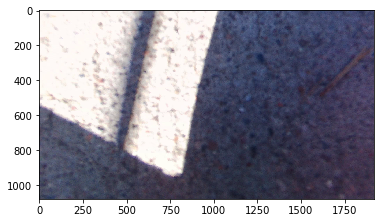

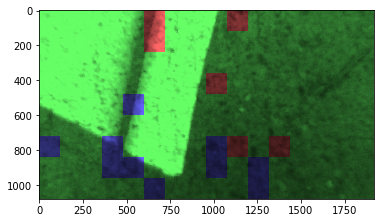

In [190]:
VideoToFrames(vid) #Passing the video to be analyzed frame by frame

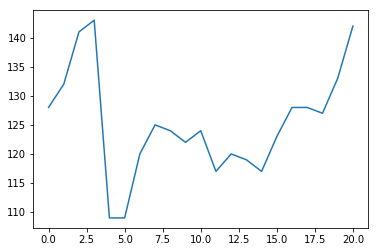

In [79]:
plt.plot(temp)